# *klustr* by Lamtharn (Hanoi) Hantrakul & Avneesh Sarwate
This notebook is intended to be the one-stop-shop for our Final project for MIR Fall 2017. 

In [1]:
# Imports
%matplotlib inline
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

from time import time
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

import pickle

# SECTION 1 : DATASET

## Loading the sample library

Our sample dataset consists of ~10,000 drum hits. We have trimmed only the first 0.25s of the drum sounds to preserve the attack portion of the drum shots, while keeping the file size computationally manageable. All drum samples are saved as `.npy` files in `./drumData`. To see how we recursively went through directories and scraped the sample type e.g `kick_1.wav` as ground truth from the filename see "Samples to Arrays notebook"

In [2]:
data_root = 'drumData'
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumSamples = {}
for d in drumNames:
    drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

Let's have a look at some of our samples

In [3]:
def plotDrumSamples(drum_dict, drum_name, color):    
    # Plot the the first 5 drum samples
    f, ax = plt.subplots(1, 5, sharey=True, figsize=(50, 10))
    for i, axis in enumerate(ax):
        axis.plot(drum_dict[drum_name][i], c=color)
        if i == 0:
            axis.set_title(drum_name + "\n", fontsize=50)

In [4]:
# Define the mapping of samples to colors used throughout the rest of the project 
colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']

drum_name	dimensions
______________________________
kick     	(5158, 12000)
tom      	(422, 12000)
snare    	(2546, 12000)
clap     	(1324, 12000)
hi.hat   	(159, 12000)
ride     	(228, 12000)
crash    	(723, 12000)


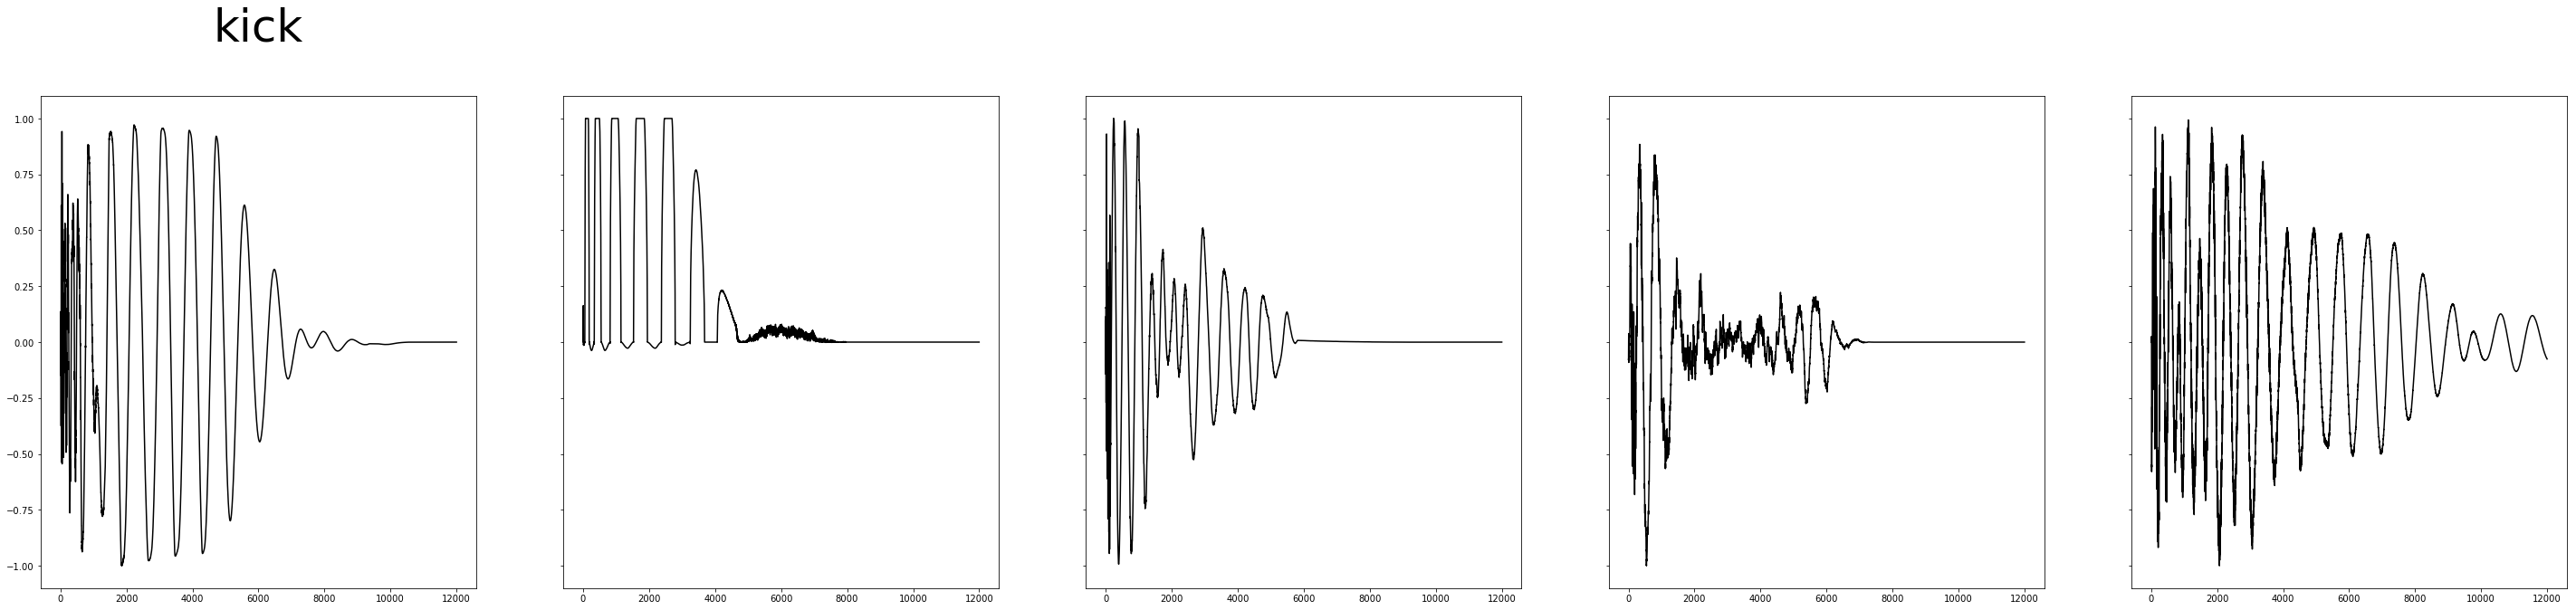

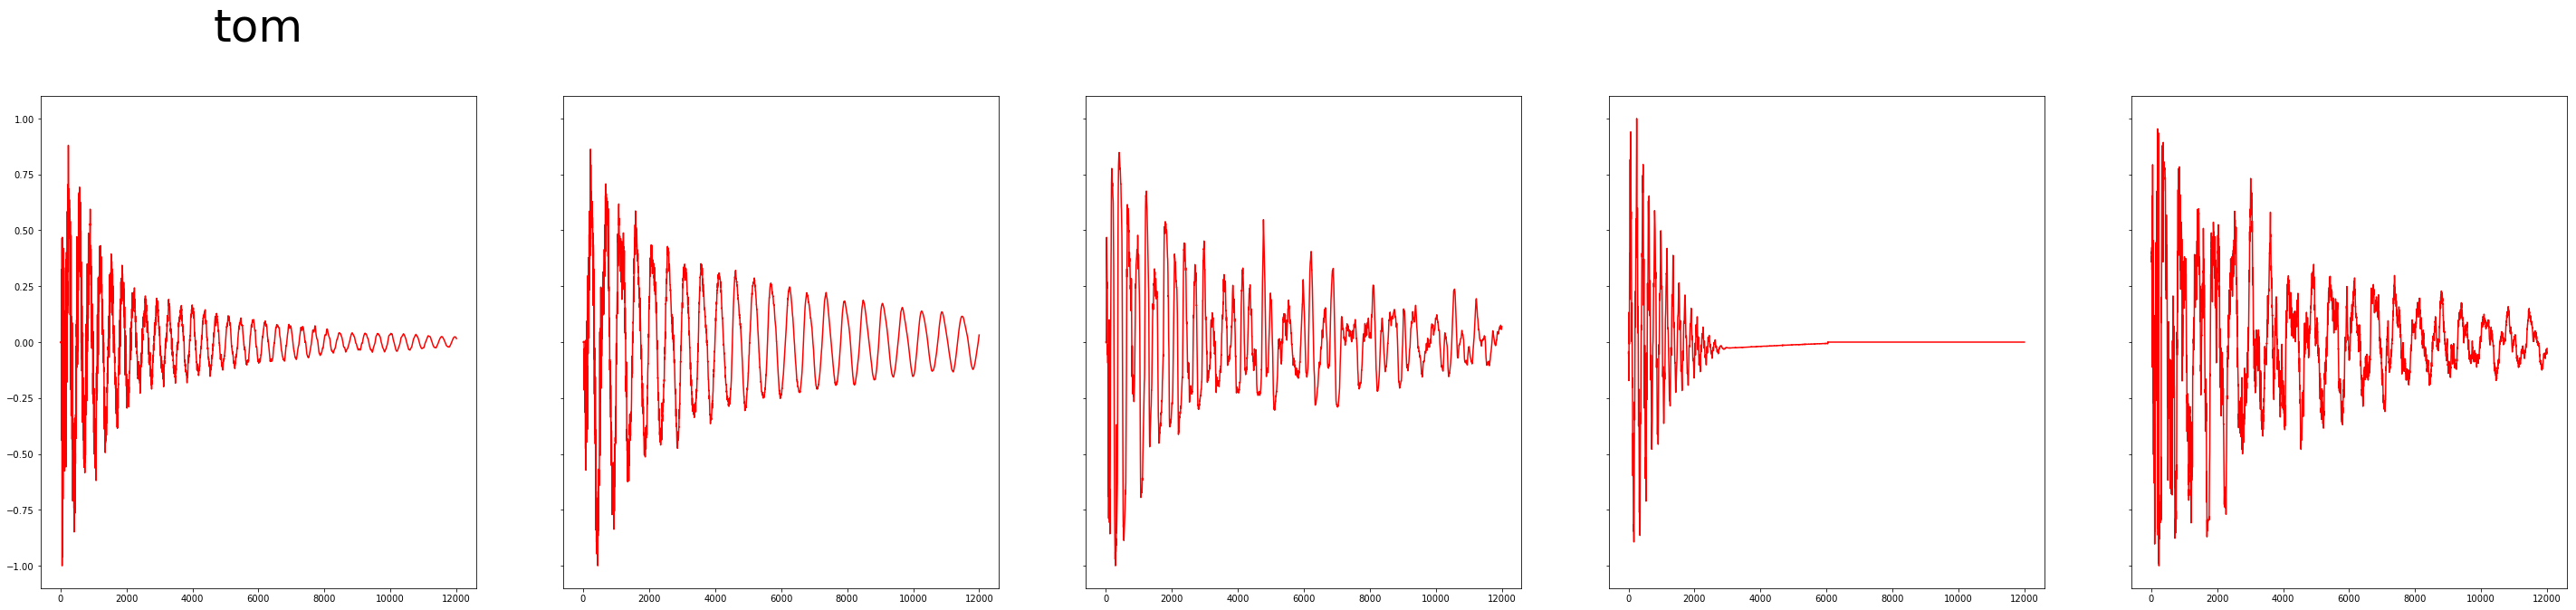

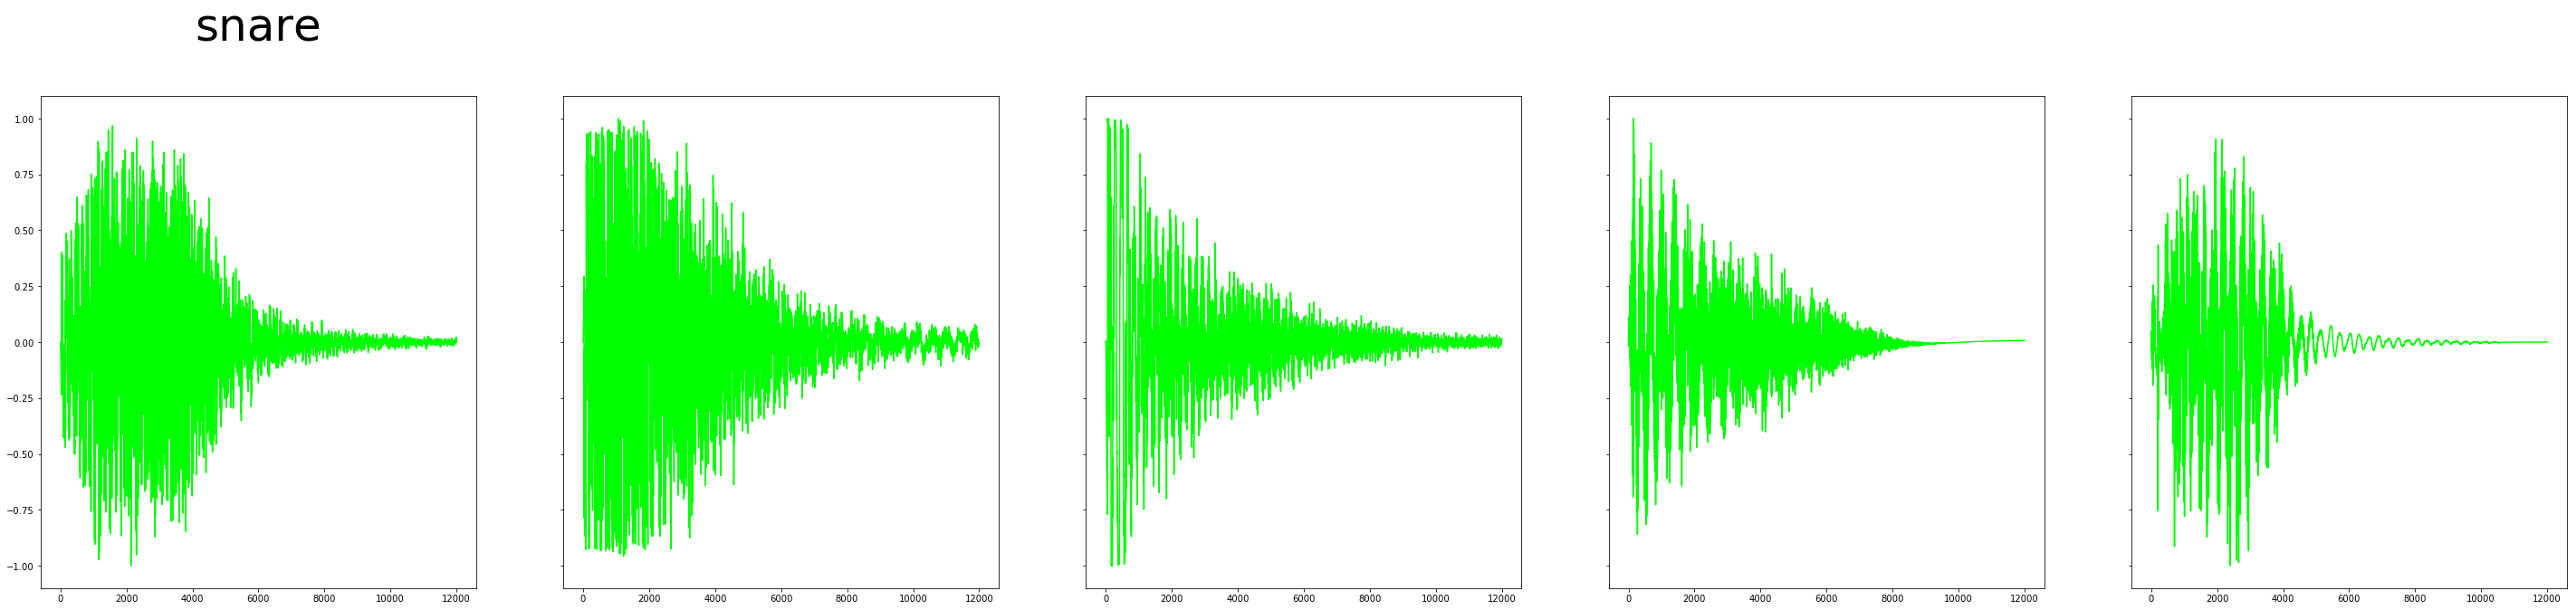

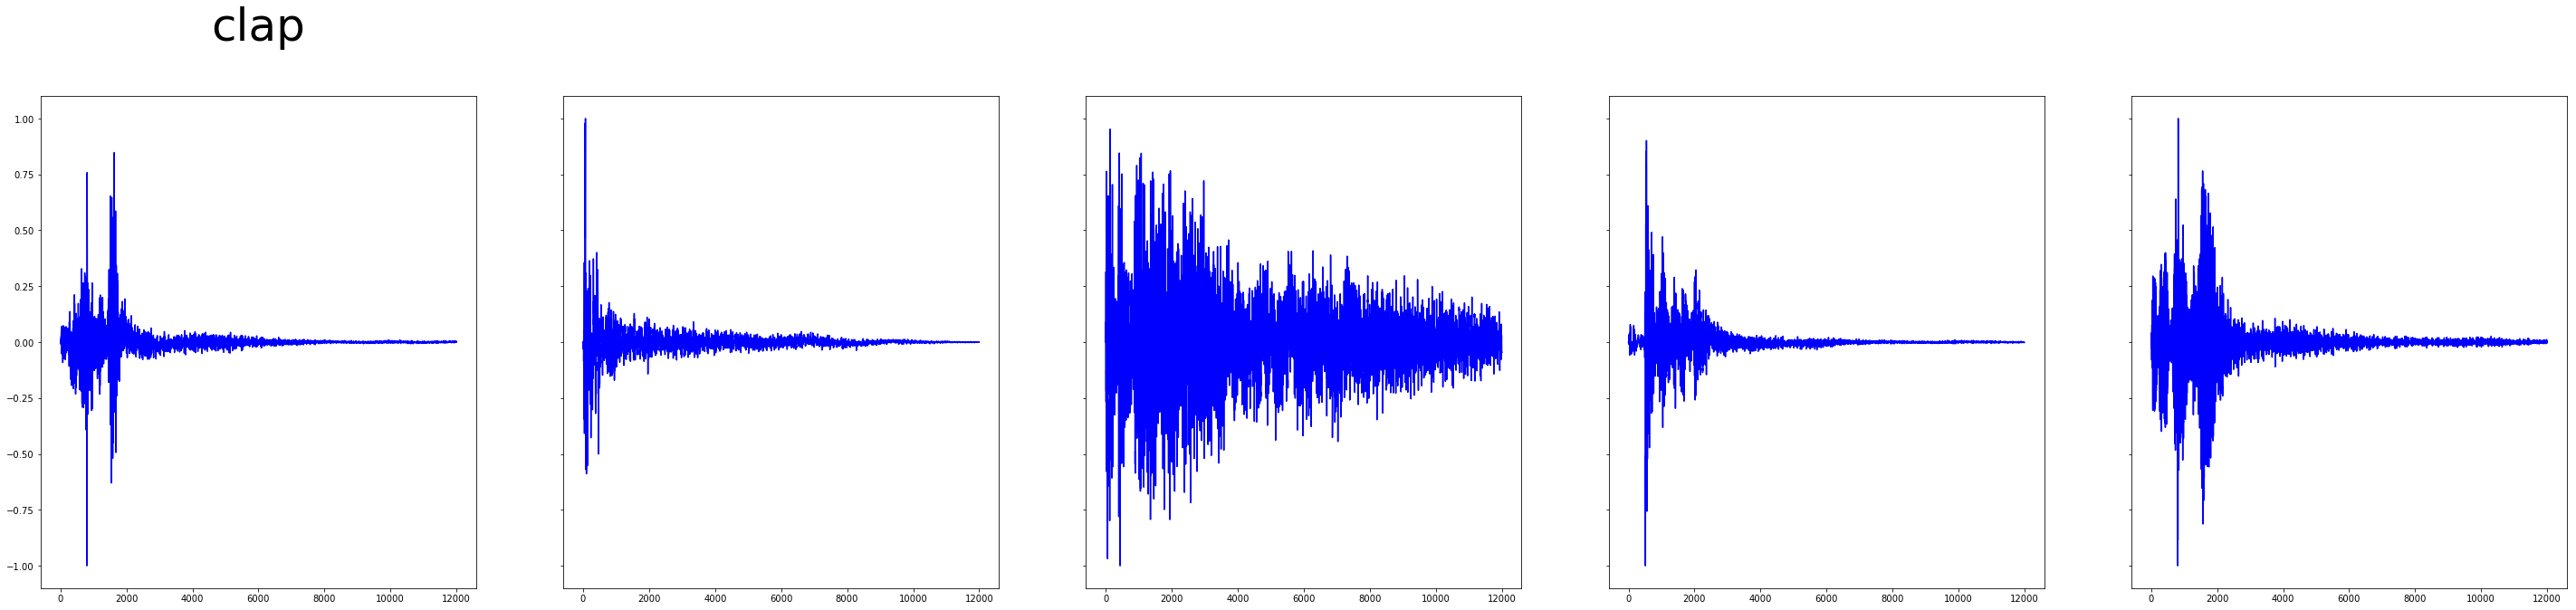

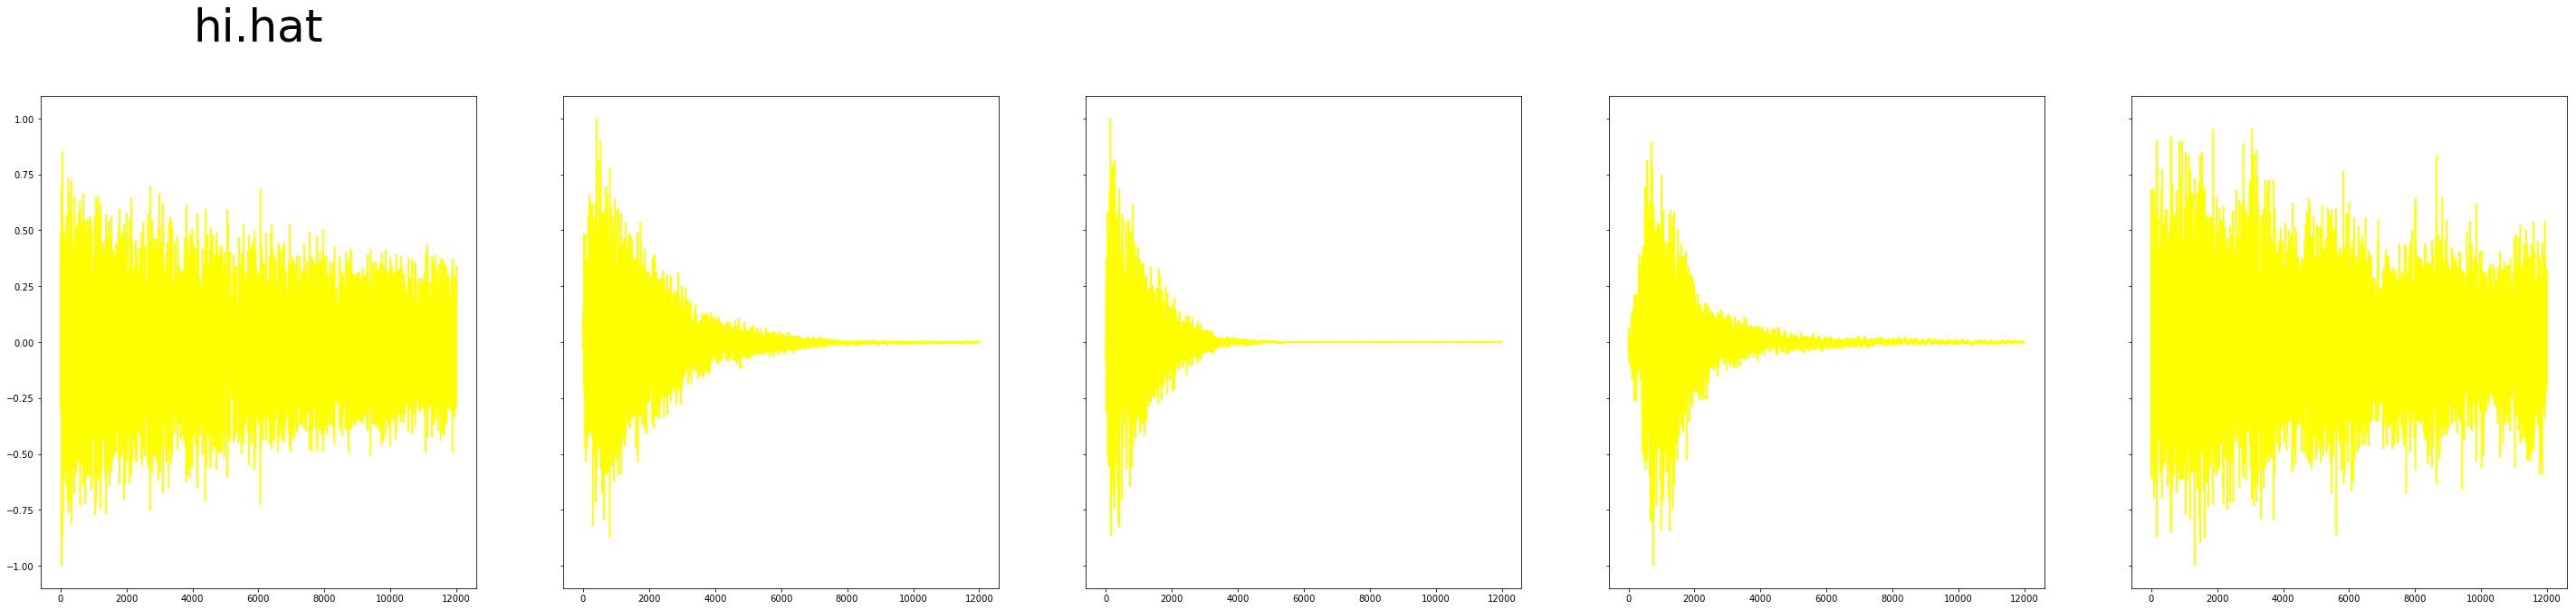

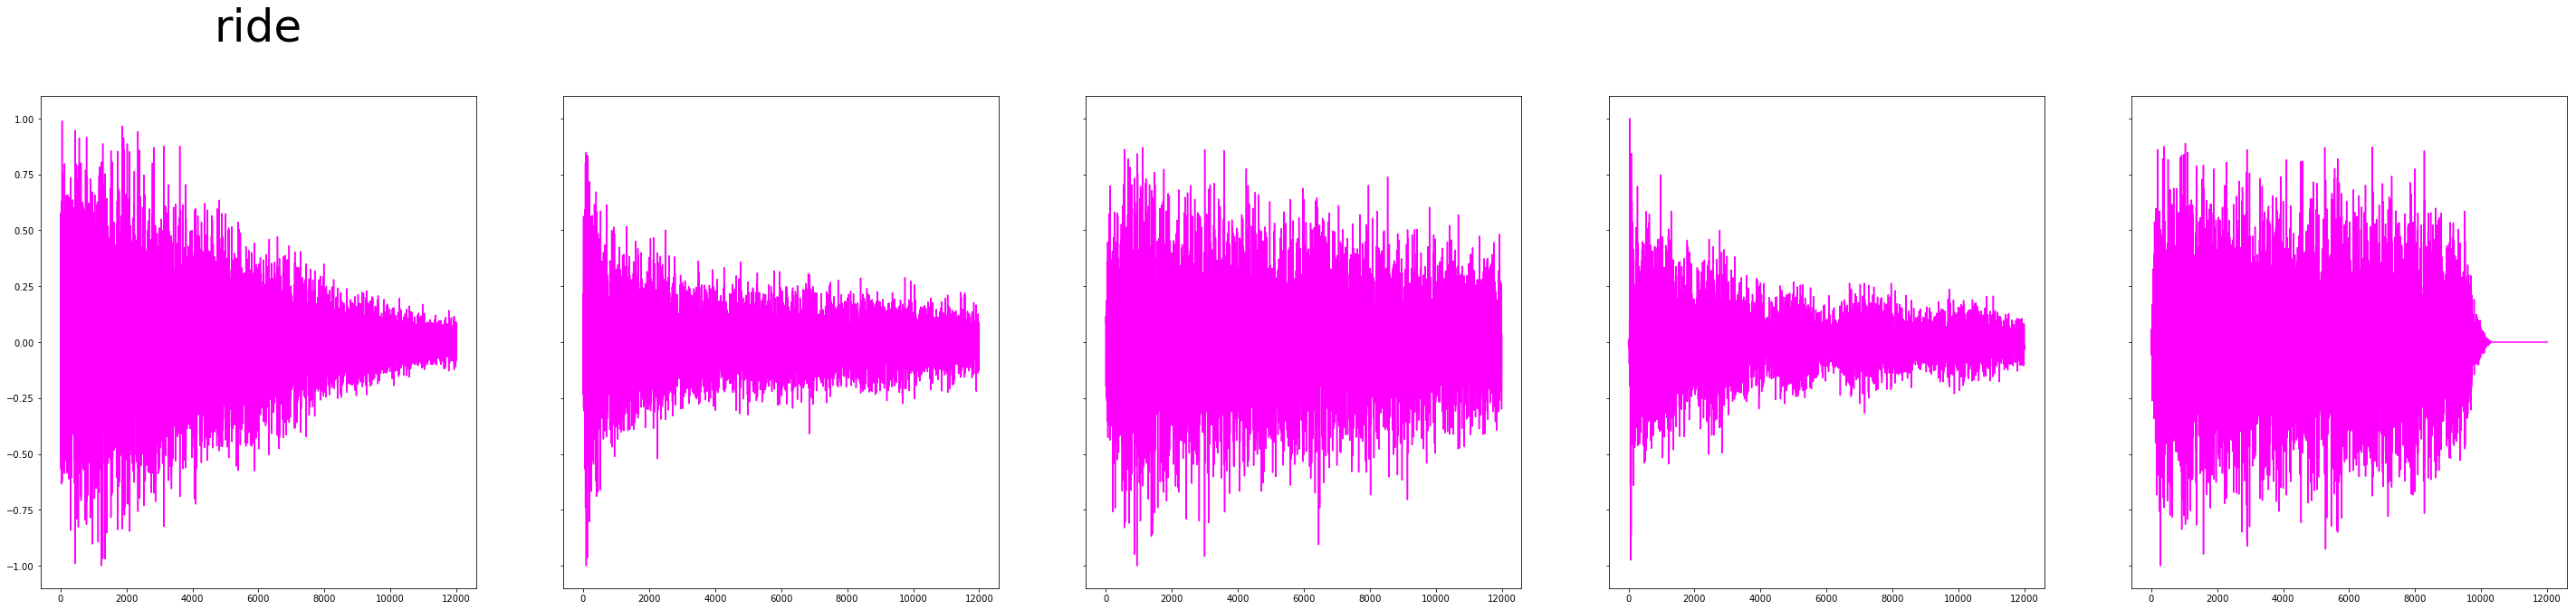

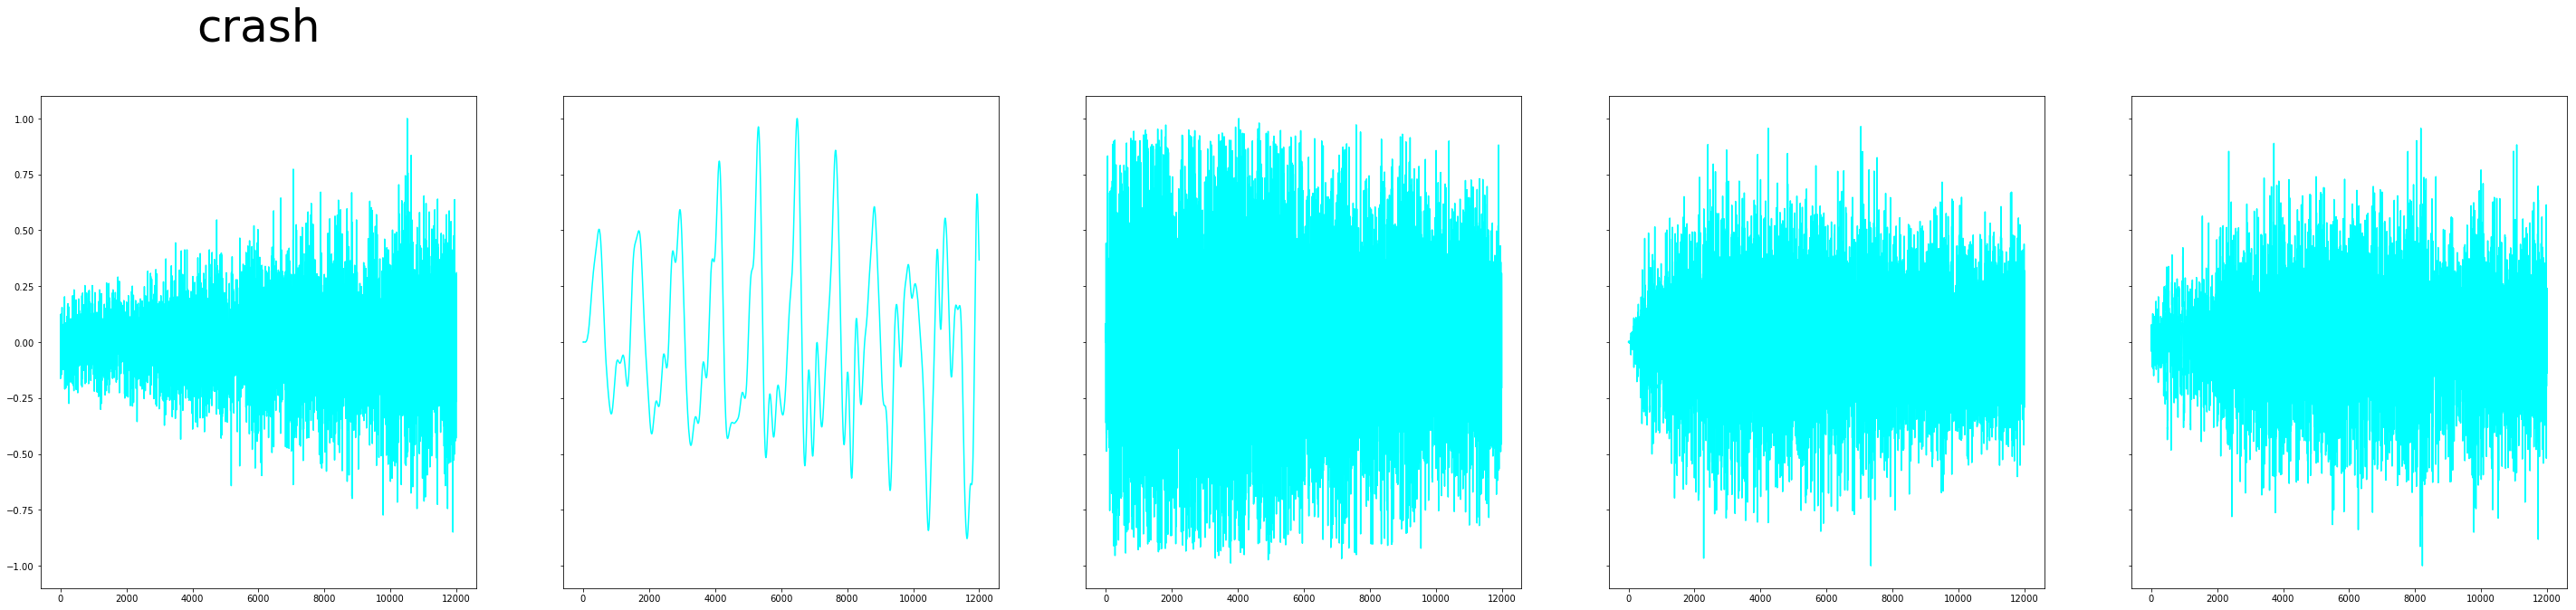

In [5]:
# Define some pretty printing
print('drum_name\tdimensions')
print('_' * 30)
for drum_name in drumNames:
    print('%-9s\t%s' % (drum_name, drumSamples[drum_name].shape))

# Plot the samples
for drum_name, color in zip(drumNames,colors):
    plotDrumSamples(drumSamples, drum_name, color)

## Loading extracted features from these Samples

We have precomputed all the features and are simply loading them into the session. Features such as the WaveNet features take a long time to encode (approximately 7 hours for the entire ~10,000 samples that are 0.25 seconds long). To look at our pipeline for extracting features from the samples defined above, look at the notebook "2. Extract Features from Sample". All features are saved as `.npy` files in `./drumFeatures`

In [7]:
def loadFeature(feature_name):
    drum_features = []
    for drum_name in drumNames: 
        file_path = './drumFeatures/' + drum_name + '_' + feature_name + '.npy'
        drum_feature = np.load(file_path)
        drum_features.extend(drum_feature)
    drum_features = np.asarray(drum_features)
    #print(feature_name + " original dim", drum_features.shape)
    print('%-9s\t%s' % (feature_name, drum_features.shape))
    drum_features = drum_features.reshape(len(drum_features),-1)
    return drum_features

def loadAllFeatures(feature_dict):   
    x_data_features = {}
    for feature_name in feature_dict:
        drum_features = loadFeature(feature_name)
        x_data_features[feature_name] = drum_features
    return x_data_features

Each of features have the following dimensionalities
    - stft = (N,32,32) 
    - mfcc = (N,30,24)
    - mir = (N,6,24)
    - wavenet = (N,23,16)

In [8]:
# Define some pretty printing
print('feature_name\t original dimensions')
print('_'*35)

# Load all the features
feature_list = ['stft','mfcc','mir','wavenet']
x_data_dict = loadAllFeatures(feature_list)

feature_name	 original dimensions
___________________________________
stft     	(10560, 32, 32)
mfcc     	(10560, 30, 24)
mir      	(10560, 6, 24)
wavenet  	(10560, 23, 16)


In order to do dimensionality reduction, we have to `flatten()` the matrices into one long feature vector.
    - stft = (N,1024) 
    - mfcc = (N,720)
    - mir = (N,144)
    - wavenet = (N,368)

In [9]:
print('feature_name\t flat dimensions')
print('_' * 35)
for feature_name in feature_list:
    print('%-9s\t%s' % (feature_name, x_data_dict[feature_name].shape))

feature_name	 flat dimensions
___________________________________
stft     	(10560, 1024)
mfcc     	(10560, 720)
mir      	(10560, 144)
wavenet  	(10560, 368)


## Create the ground truth lables

The ground truth class labels are simply: 
    * 0 = kick
    * 1 = tom 
    * 2 = snare 
    * 3 = clap 
    * 4 = hi.hat 
    * 5 = ride
    * 6 = crash 

In [17]:
drumLabels = []
for i, drum_name in enumerate(drumNames):
    file_path = './drumFeatures/' + drum_name + '_' + 'stft' + '.npy'
    STFT_feat = np.load(file_path)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data_labels = np.asarray(drumLabels)

As a sanity check, we would expect the grouth truth labels to just make a series of "stairs" from 0 to 6 if we plotted it

('y_data_labels.shape:', (10560,))


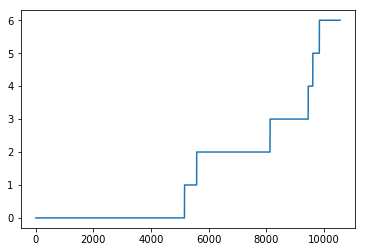

In [18]:
print("y_data_labels.shape:", y_data_labels.shape)
plt.figure()
plt.plot(y_data_labels)

## Create ground truth color map

We define an array to hold the colors of each sample. When we plot all the samples in 2D, we can go back and color in all the samples to visually see the quality of clustering.

In [40]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

# SECTION 2 : UNSUPERVISED FEATURE SELECTION

We reason that the features useful for unsupervised clustering in the original high dimensional space (~1000) will be useful for clustering after dimensionality reduction in 2 dimensions. Since we know ground truth and the the number of clusters to be 7, we can evaluate the clustering quality using a **Silhouette Coefficient**. 

The definition from sk-learn's documentation is as follows:
"The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b)."
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

There are other metrics that can be used to specifically evaluate the quality of unsupervised K-means clustering given the ground truth labels (not available in most cases, but available in our case). These are namely:
- **Homogeneity:** "A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class." 
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score
- **Completeness:** "A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster." http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html
- **V-measure score:** "The V-measure is the harmonic mean between homogeneity and completeness" http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score

In [82]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# This code is adapted from sk-learn's tutorial.http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

def evalKmeans(data_X, data_Y):
    np.random.seed(42)
    data = data_X

    n_samples, n_features = data.shape
    n_drumtypes = 7
    labels = data_Y

    sample_size = 300

    print("n_drumtypes: %d, \t n_samples %d, \t n_features %d"
          % (n_drumtypes, n_samples, n_features))

    print(65 * '_')
    print('init\t\ttime\thomo\tcompl\tv-meas\tsilhouette')
    
    bench_k_means(KMeans(init='k-means++', n_clusters=n_drumtypes, n_init=10),
              name="k-means++", data=data, labels = data_Y, sample_size=sample_size)

    bench_k_means(KMeans(init='random', n_clusters=n_drumtypes, n_init=10),
                  name="random", data=data, labels = data_Y, sample_size=sample_size)

    # in this case the seeding of the centers is deterministic, hence we run the
    # kmeans algorithm only once with n_init=1
    pca = PCA(n_components=n_drumtypes).fit(data)
    bench_k_means(KMeans(init=pca.components_, n_clusters=n_drumtypes, n_init=1),
                  name="PCA-based",
                  data=data,
                    labels = data_Y,
                 sample_size=sample_size)

def bench_k_means(estimator, name, data, labels, sample_size):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), 
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

### Kmeans on STFT features

In [83]:
evalKmeans(x_data_dict['stft'], y_data_labels)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 1024
_________________________________________________________________
init		time	homo	compl	v-meas	silhouette
k-means++	6.58s	0.507	0.439	0.470	0.214
random   	9.00s	0.508	0.439	0.471	0.246
PCA-based	1.27s	0.508	0.439	0.471	0.195


### Kmeans on MFCC features

In [84]:
evalKmeans(x_data_dict['mfcc'], y_data_labels)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 720
_________________________________________________________________
init		time	homo	compl	v-meas	silhouette
k-means++	6.36s	0.483	0.363	0.414	0.175
random   	5.25s	0.482	0.362	0.413	0.192
PCA-based	0.79s	0.482	0.362	0.413	0.178


### Kmeans on MIR features

In [85]:
evalKmeans(x_data_dict['mir'], y_data_labels)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 144
_________________________________________________________________
init		time	homo	compl	v-meas	silhouette
k-means++	2.04s	0.379	0.302	0.336	0.140
random   	1.53s	0.378	0.302	0.336	0.150
PCA-based	0.22s	0.369	0.277	0.316	0.103


### Kmeans on WaveNet features

In [86]:
evalKmeans(x_data_dict['wavenet'], y_data_labels)

n_drumtypes: 7, 	 n_samples 10560, 	 n_features 368
_________________________________________________________________
init		time	homo	compl	v-meas	silhouette
k-means++	2.67s	0.246	0.184	0.210	0.272
random   	2.67s	0.246	0.184	0.210	0.278
PCA-based	0.51s	0.255	0.204	0.226	0.249


Based from these results, **we expect STFT features perform the best when reducing to two dimensions**. This is because it performs consistently well across all metrics in unsupervised Kmeans clustering in the original high dimensional space.

We however note that WaveNet features had the best silhouette scores, indicating that there is good intraclass separability, but did not provide any useful features for classification to unsupervised Kmeans. This makes sense, since the Wavenet features were trained to reconstruct audio input and output in an autoencoder. The features may thus not be useful for classification. 

# SECTION 4 : METRICS

## Define Metrics for Evaluating the quality of 2D Map
### Silhouette Coefficient (Clustering score)
The first metric is the **Silhouette Coefficient**. However, as we noted in our paper, the Silhouette Score does not account for the spatial distribution and gemometry of clusters in 2D space, something that is essential to a navigable 2D interface. Thus we define two additional metrics called **Roundess** and **Overlap** which specifically measures the geometry of the 2D map.

In [10]:
def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    return silhouette_avg

### Roundness and Overlap (Geometric score)
The **Roundess** and **Overlap** are contained in a dictionary of metrics returned by function `clusterGeometryMetrics()` that we explored during the course of the project. We selected these two metrics as they matched good plots when we visually inspected them.

In [27]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

def clusterGeometryMetrics(drum_points, labels):
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    roundness_np = np.asarray(roundness)
    roundness_mean = np.mean(roundness_np)
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
   #the polygons themselves for further processing 
    polygons = drum_polygons.values() + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['roundness_mean'] = roundness_mean
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

# Final Score
We define a final score as the addition: `Sillhouete Score + Roundess Score + Overlap Score`. A higher score means that the mapping produce good class separation and wtih nice, spaced out clusters for easy navigation and visual interpretation

In [28]:
def evalMetrics(data, cluster_labels):
    silhouette_score = computeSilCoeff(data, cluster_labels)
    geometry_dict = clusterGeometryMetrics(data, cluster_labels)
    final_score = silhouette_score + geometry_dict['roundness_mean'] + geometry_dict['overlap_ratio']
    return (silhouette_score,geometry_dict['roundness_mean'],geometry_dict['overlap_ratio'],final_score)

# SECTION 5:  Evaluating 2D dimensionality reduction

## Section 5A: PCA 2D
We first use Principal Component Analysis (PCA) and plot the first two principal components.

In [29]:
def returnPCA(data):
    reduced_data = PCA(n_components=2).fit_transform(data)
    scaler = MinMaxScaler()
    scaler.fit(reduced_data)
    return scaler.transform(reduced_data)

def plot2D(reduced_data, colorMap, dim_red_type, feature):
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colorMap,s=2)
    plt.title(dim_red_type + " on " + feature)
    plt.show()
    
def printMetrics(scores):
    print('metric\t\t score')
    print('_' * 35)
    print('%-9s\t%s' % ('Silhouette', scores[0]))
    print('%-9s\t%s' % ('Roundess', scores[1]))
    print('%-9s\t%s' % ('Overlap', scores[2]))
    print('-' * 35)
    print('%-9s\t%s' % ('Final Score', scores[3]))

In [30]:
# Return all PCA reduced data for each feature and store in a dictionary
pca_data_dict = {}
feature_list = ['stft','mfcc','mir','wavenet']
for feature_name in feature_list:
    pca_data_dict[feature_name] = returnPCA(x_data_dict[feature_name])

In [31]:
# Return all metrics for each PCA+feature combination and store in a dictionary
pca_scores_dict = {}
for feature_name in feature_list:
    pca_scores_dict[feature_name] = evalMetrics(pca_data_dict[feature_name], y_data_labels)

### 2D PCA on STFT

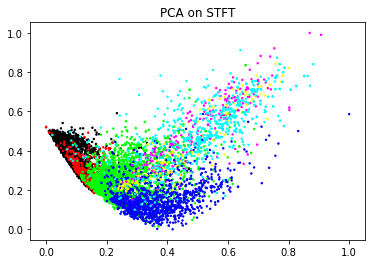

metric		 score
___________________________________
Silhouette	0.104715
Roundess 	0.709278188112
Overlap  	0.274652837578
-----------------------------------
Final Score	1.08864573968


In [219]:
plot2D(pca_data_dict['stft'],colorMap,'PCA','STFT')
printMetrics(pca_scores_dict['stft'])

### 2D PCA on MFCC

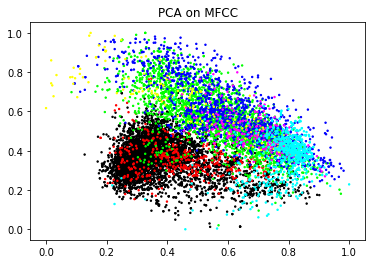

metric		 score
___________________________________
Silhouette	-0.01703560253
Roundess 	0.790645239509
Overlap  	0.235034596119
-----------------------------------
Final Score	1.0086442331


In [220]:
plot2D(pca_data_dict['mfcc'],colorMap,'PCA','MFCC')
printMetrics(pca_scores_dict['mfcc'])

### 2D PCA on MIR

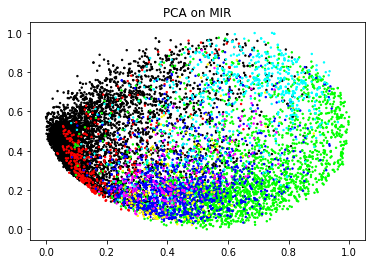

metric		 score
___________________________________
Silhouette	-0.034397896303
Roundess 	0.899108607541
Overlap  	0.18207372045
-----------------------------------
Final Score	1.04678443169


In [221]:
plot2D(pca_data_dict['mir'],colorMap,'PCA','MIR')
printMetrics(pca_scores_dict['mir'])

### 2D PCA on WaveNet

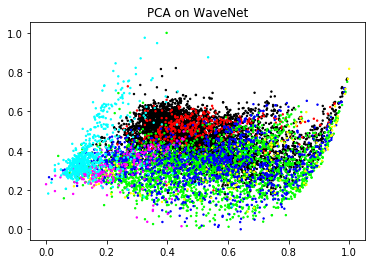

metric		 score
___________________________________
Silhouette	-0.105737
Roundess 	0.778159898814
Overlap  	0.209172115601
-----------------------------------
Final Score	0.881594536874


In [222]:
plot2D(pca_data_dict['wavenet'],colorMap,'PCA','WaveNet')
printMetrics(pca_scores_dict['wavenet'])

## Section 5B: TSNE 2D

### Finding optimal perplexity and iterations
There are **3 hyperparameters** when using TSNE: 
- **Number of dimensions**: 2 in this case
- **Perplexity**: can be interpreted as the "attention" given to separate clusters
- **Iterations**: Number of to run the algorithm (it uses gradient descent)

Before we can compare TSNE plots with PCA, we must first do a grid search over a range of perplexities and iterations and choose the combination that yields the highest final score as defined above. We then choose this combination as the "representative" TSNE embedding and compare this embedding with other dimensionality reduction techniques.

In [32]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

def gridSearchTSNE(x_data):
    tnse_embeddings= []
    perplexities = [2, 5, 30, 50, 100]
    iterations = [250, 500, 1000, 2000, 5000]
    for i, perplexity in enumerate(perplexities):
        for j, iteration in enumerate(iterations):
            print("perplexity: ",perplexity,"iteration",iteration)
            %time tsne_embedding = get_scaled_tsne_embeddings(x_data,perplexity,iteration)
            tnse_embeddings.append(tsne_MIR)
    return tnse_embeddings

def gridSearchTSNEallFeatures(x_data_dict):
    tsne_data_dict = {}
    feature_list = ['stft','mfcc','mir','wavenet']
    for feature_name in feature_list:
        tsne_data_dict[feature_name] = gridSearchTSNE(x_data_dict[feature_name])
    return tsne_data_dict

In [33]:
#tsne_data_dict = gridSearchTSNEallFeatures(x_data_dict)
#with open('./drumEmbeddings/tsne_map_all_features.pkl','wb') as f:
#    pickle.dump(tsne_data_dict, f)

We will **not** be running the above block in this notebook. `gridSearchTSNEallFeatures()` takes a total computation time of approximately 12 hours (about 3 hours per feature). Instead we will load the pre-computed TSNE features in `.pkl` format located in `./drumEmbeddings`. We will then plot a sample of the maps generated across this grid search to get an intuition on how perplexity and iterations affect the quality of the 2D Map. 

In [34]:
def loadEmbeddingMap(feature_name):
    file_path = './drumEmbeddings/tsne_map_' + feature_name + '.pkl'
    embedding = pickle.load(open(file_path,'rb'))
    return embedding
  
def loadAllTSNEmap(feature_dict):   
    tsne_data_dict = {}
    for feature_name in feature_dict:
        feature_embedding = loadEmbeddingMap(feature_name)
        tsne_data_dict[feature_name] = feature_embedding
    return tsne_data_dict

In [36]:
# Load all the features
feature_list = ['stft','mfcc','mir','wavenet']
TSNE_map_dict = loadAllTSNEmap(feature_list)

Helper function to plot the different TSNE maps under various perplexities and iterations

In [38]:
def plotTSNEMap(embedding, labels):
    perplexities = [2, 5, 30, 50, 100]
    iterations = [250, 500, 1000, 2000, 5000]
    fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(40, 40))

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            current_plot = i * len(iterations) + j
            col.scatter(embedding[current_plot].T[0], 
                        embedding[current_plot].T[1], 
                        c=colorMap,
                        s=1)      
            col.set_title("perplexities: " + str(perplexities[i]) + " iterations: " + str(iterations[j]))
   
    plt.show()

### Grid search over TSNE for STFT

In [41]:
tnse_stft = TSNE_map_dict['stft']
plotTSNEMap(tnse_stft,y_data_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Section 5C: UMAP 2D

### Finding optimal perplexity and iterations
There are **4 hyperparameters** when using UMAP. Definitions from the author of UMAP are as follows (https://github.com/lmcinnes/umap): 
- **Number of dimensions**: 2 in this case
- **Neighbours**: "This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default."
- **Distances**: "This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default."
- **Metric**: "This determines the choice of metric used to measure distance in the input space. A wide variety of metrics are already coded, and a user defined function can be passed as long as it has been JITd by numba."

Like TSNE, we must first do a grid search over a range of neighbours and distances and choose the combination that yields the highest final score as defined above. We then choose this combination as the "representative" UMAP embedding and compare this embedding with other dimensionality reduction techniques.

In [168]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

def gridSearchUMAP(x_data):
    umap_embeddings = []
    neighbours = [5, 10, 15, 30, 50]
    distances = [0.000, 0.001, 0.01, 0.1, 0.5]
    for i, neighbour in enumerate(neighbours):
        for j, distance in enumerate(distances):
            start_time = time.time()
            print("neighbour: ",neighbour,"distance",distance)
            %time umap_embedding = get_scaled_umap_embeddings(x_data, neighbour, distance)
            umap_embeddings.append(umap_embedding)
    return umap_embeddings

def gridSearchUMAPallFeatures(x_data_dict):
    umap_data_dict = {}
    feature_list = ['stft','mfcc','mir','wavenet']
    for feature_name in feature_list:
        umap_data_dict[feature_name] = gridSearchUMAP(x_data_dict[feature_name])
    return umap_data_dict

In [169]:
#umap_data_dict = gridSearchUMAPallFeatures(x_data_dict)
#with open('./drumEmbeddings/umap_map_all_features.pkl','wb') as f:
#    pickle.dump(umap_data_dict, f)

We will **not** be running the above block in this notebook. `gridSearchUMAPallFeatures()` takes approximately 30 minutes to compute because UMAP in general is faster than TSNE. Instead we will load the pre-computed UMAP embeddings in `.pkl` format located in `./drumEmbeddings`. We will then plot a sample of the maps generated across this grid search to get an intuition on how neighbours and distances affect the quality of the 2D Map. 

In [231]:
umap_map_dict = pickle.load(open('./drumEmbeddings/umap_map_all_features.pkl','rb'))

Helper function to plot the different UMAP maps under various neighbours and distances

In [224]:
def plotUMAPmap(embedding, labels):
    neighbours = [5, 10, 15, 30, 50]
    distances = [0.001, 0.01, 0.1, 0.5]
    fig, ax = plt.subplots(nrows=len(neighbours), 
                       ncols=len(distances),
                       figsize=(30, 30))

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            current_plot = i * len(distances) + j
            col.scatter(embedding[current_plot].T[0], 
                        embedding[current_plot].T[1], 
                        c=colorMap,
                        s=1)
            (s_score, r_score, o_score, f_score) = evalMetrics(embedding[current_plot], labels)
            col.set_title("neighbours: " + str(neighbours[i]) + " distances: " + str(distances[j]) + '\n' +
                         "final score: " + str(round(f_score,5)))
    plt.show()

### Grid search over TSNE for STFT

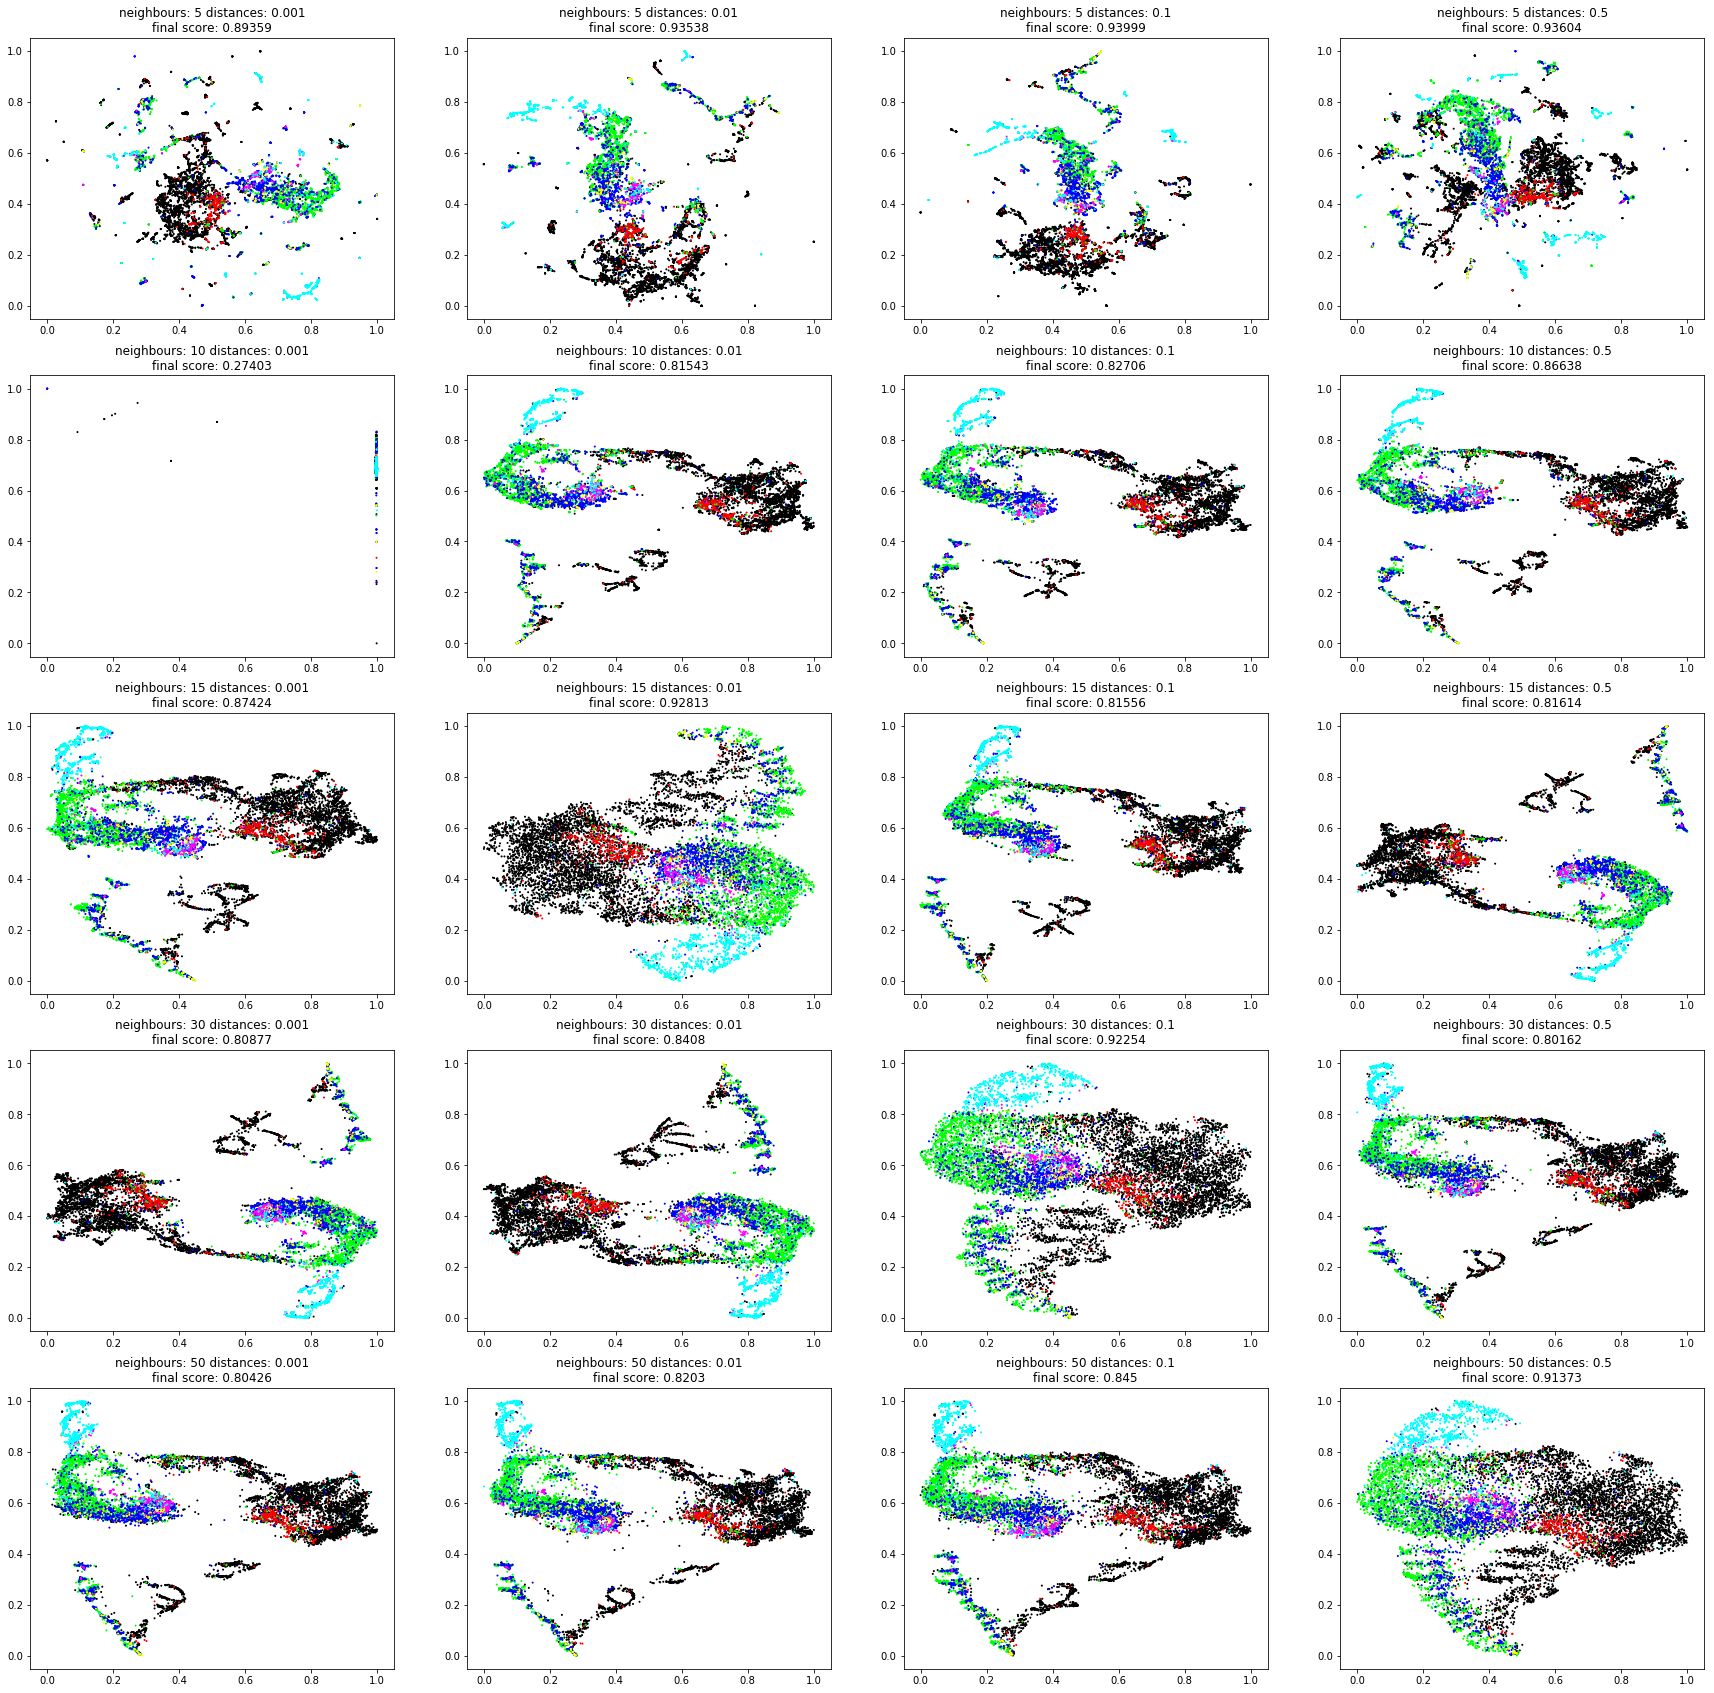

In [225]:
plotUMAPmap(umap_map_dict['stft'],y_data_labels)

Note how UMAP produces some very odd looking plots at certain combination of neighbours and distances. We believe this is due to UMAP being a new algorithm; many bugs and edge cases haven't been fixed yet. For example, we obtained these plots approximately 12 hours after an issue on GitHub was resolved based on zero divisions.

### Grid search over UMAP for MFCC

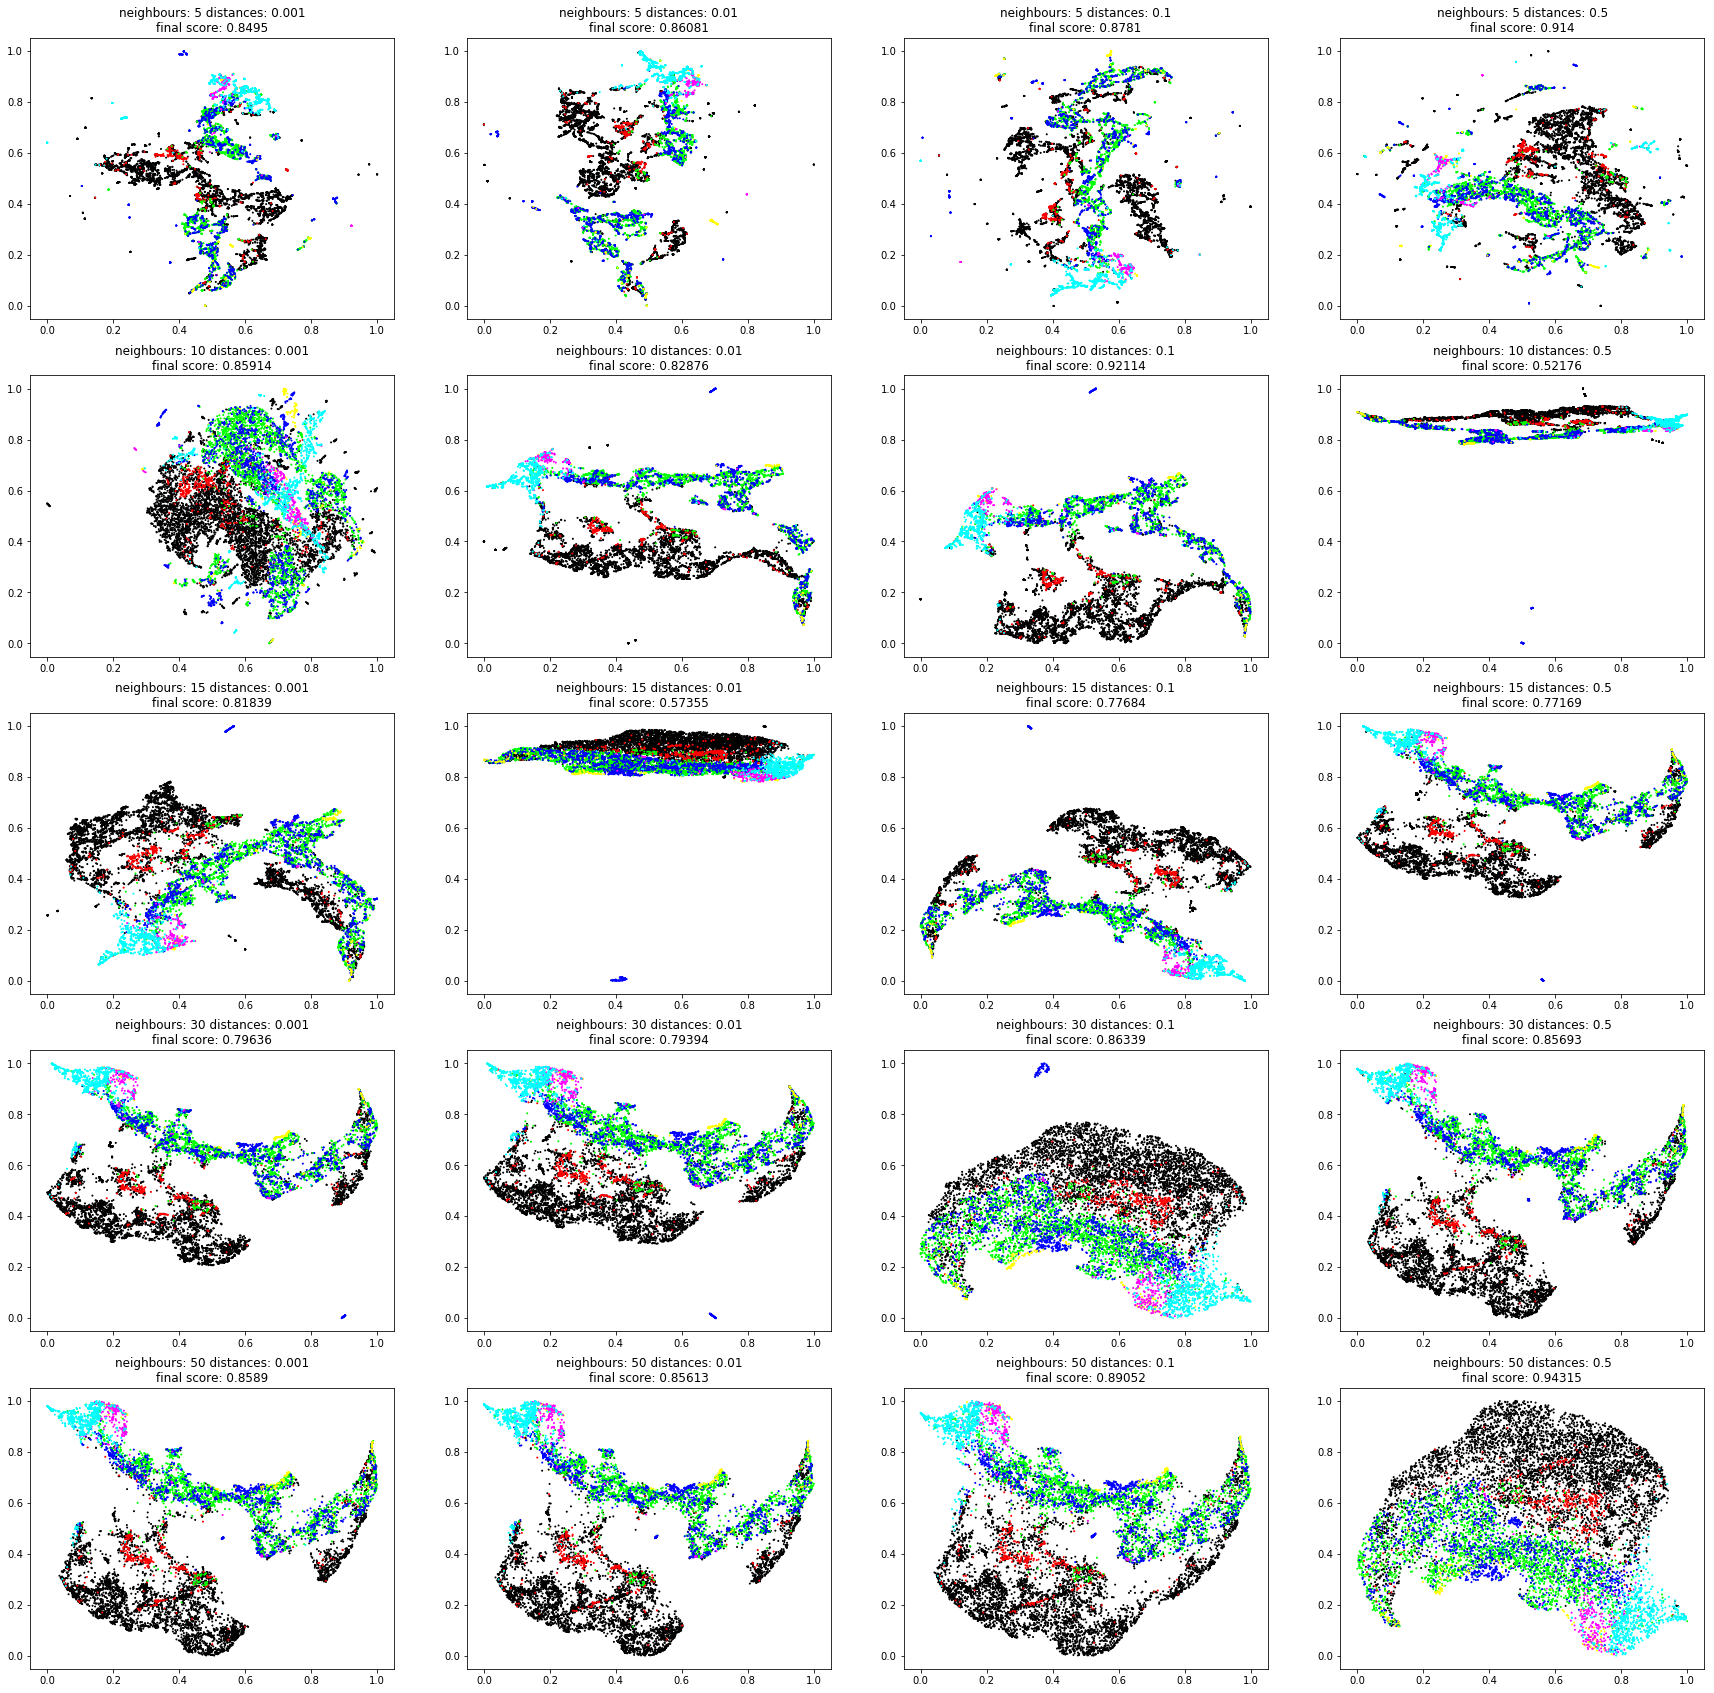

In [226]:
plotUMAPmap(umap_map_dict['mfcc'],y_data_labels)

### Grid search over UMAP for MIR

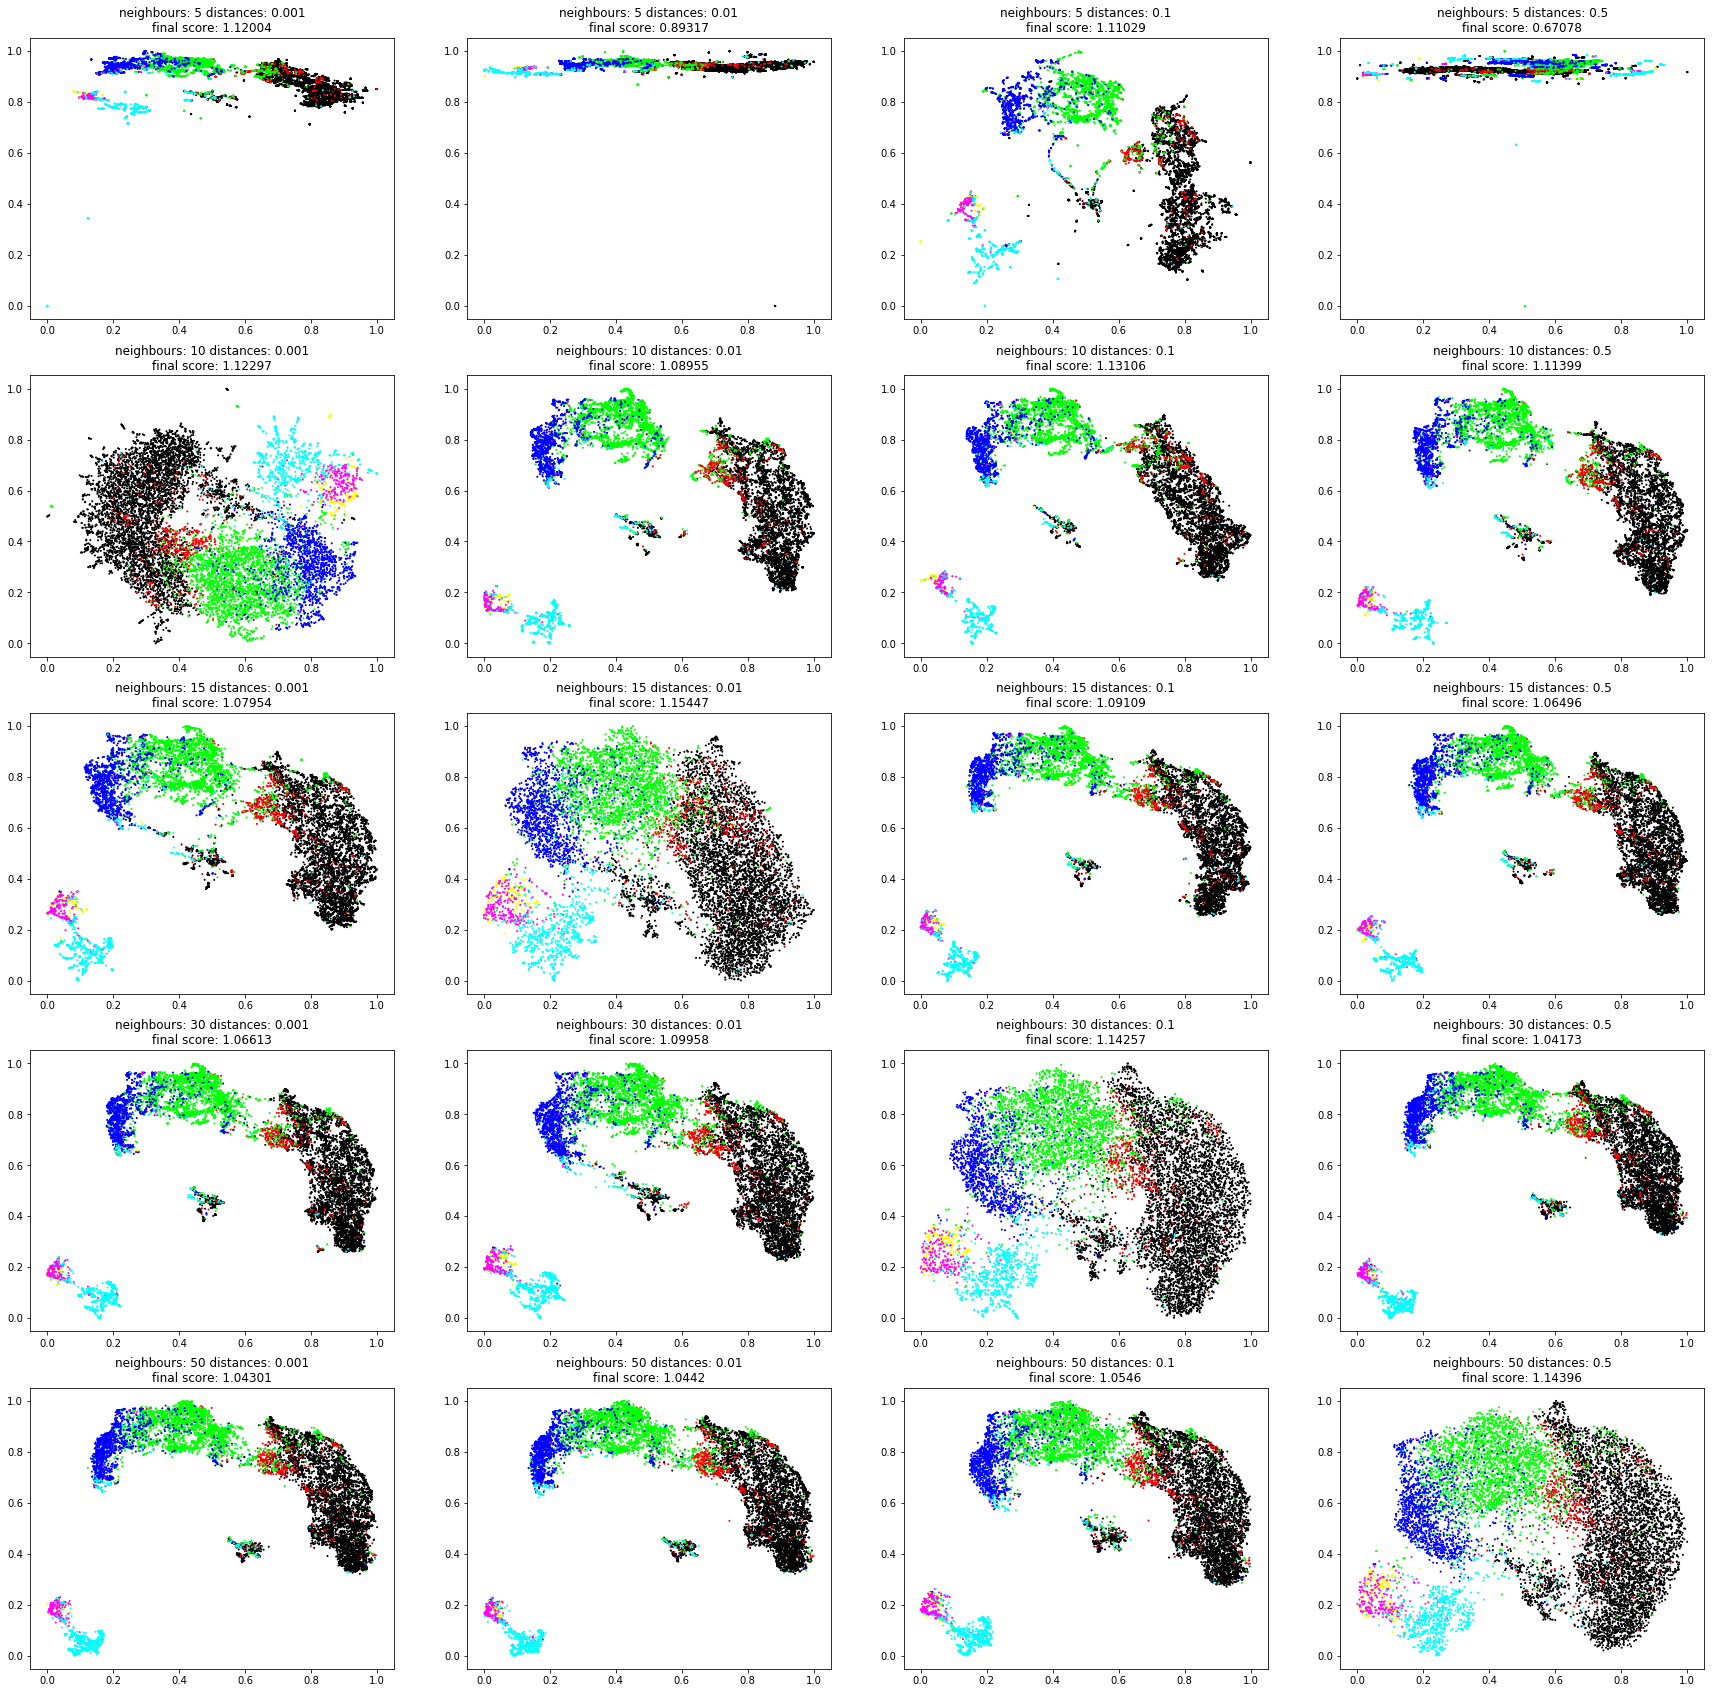

In [227]:
plotUMAPmap(umap_map_dict['mir'],y_data_labels)

### Grid search over UMAP for WaveNet

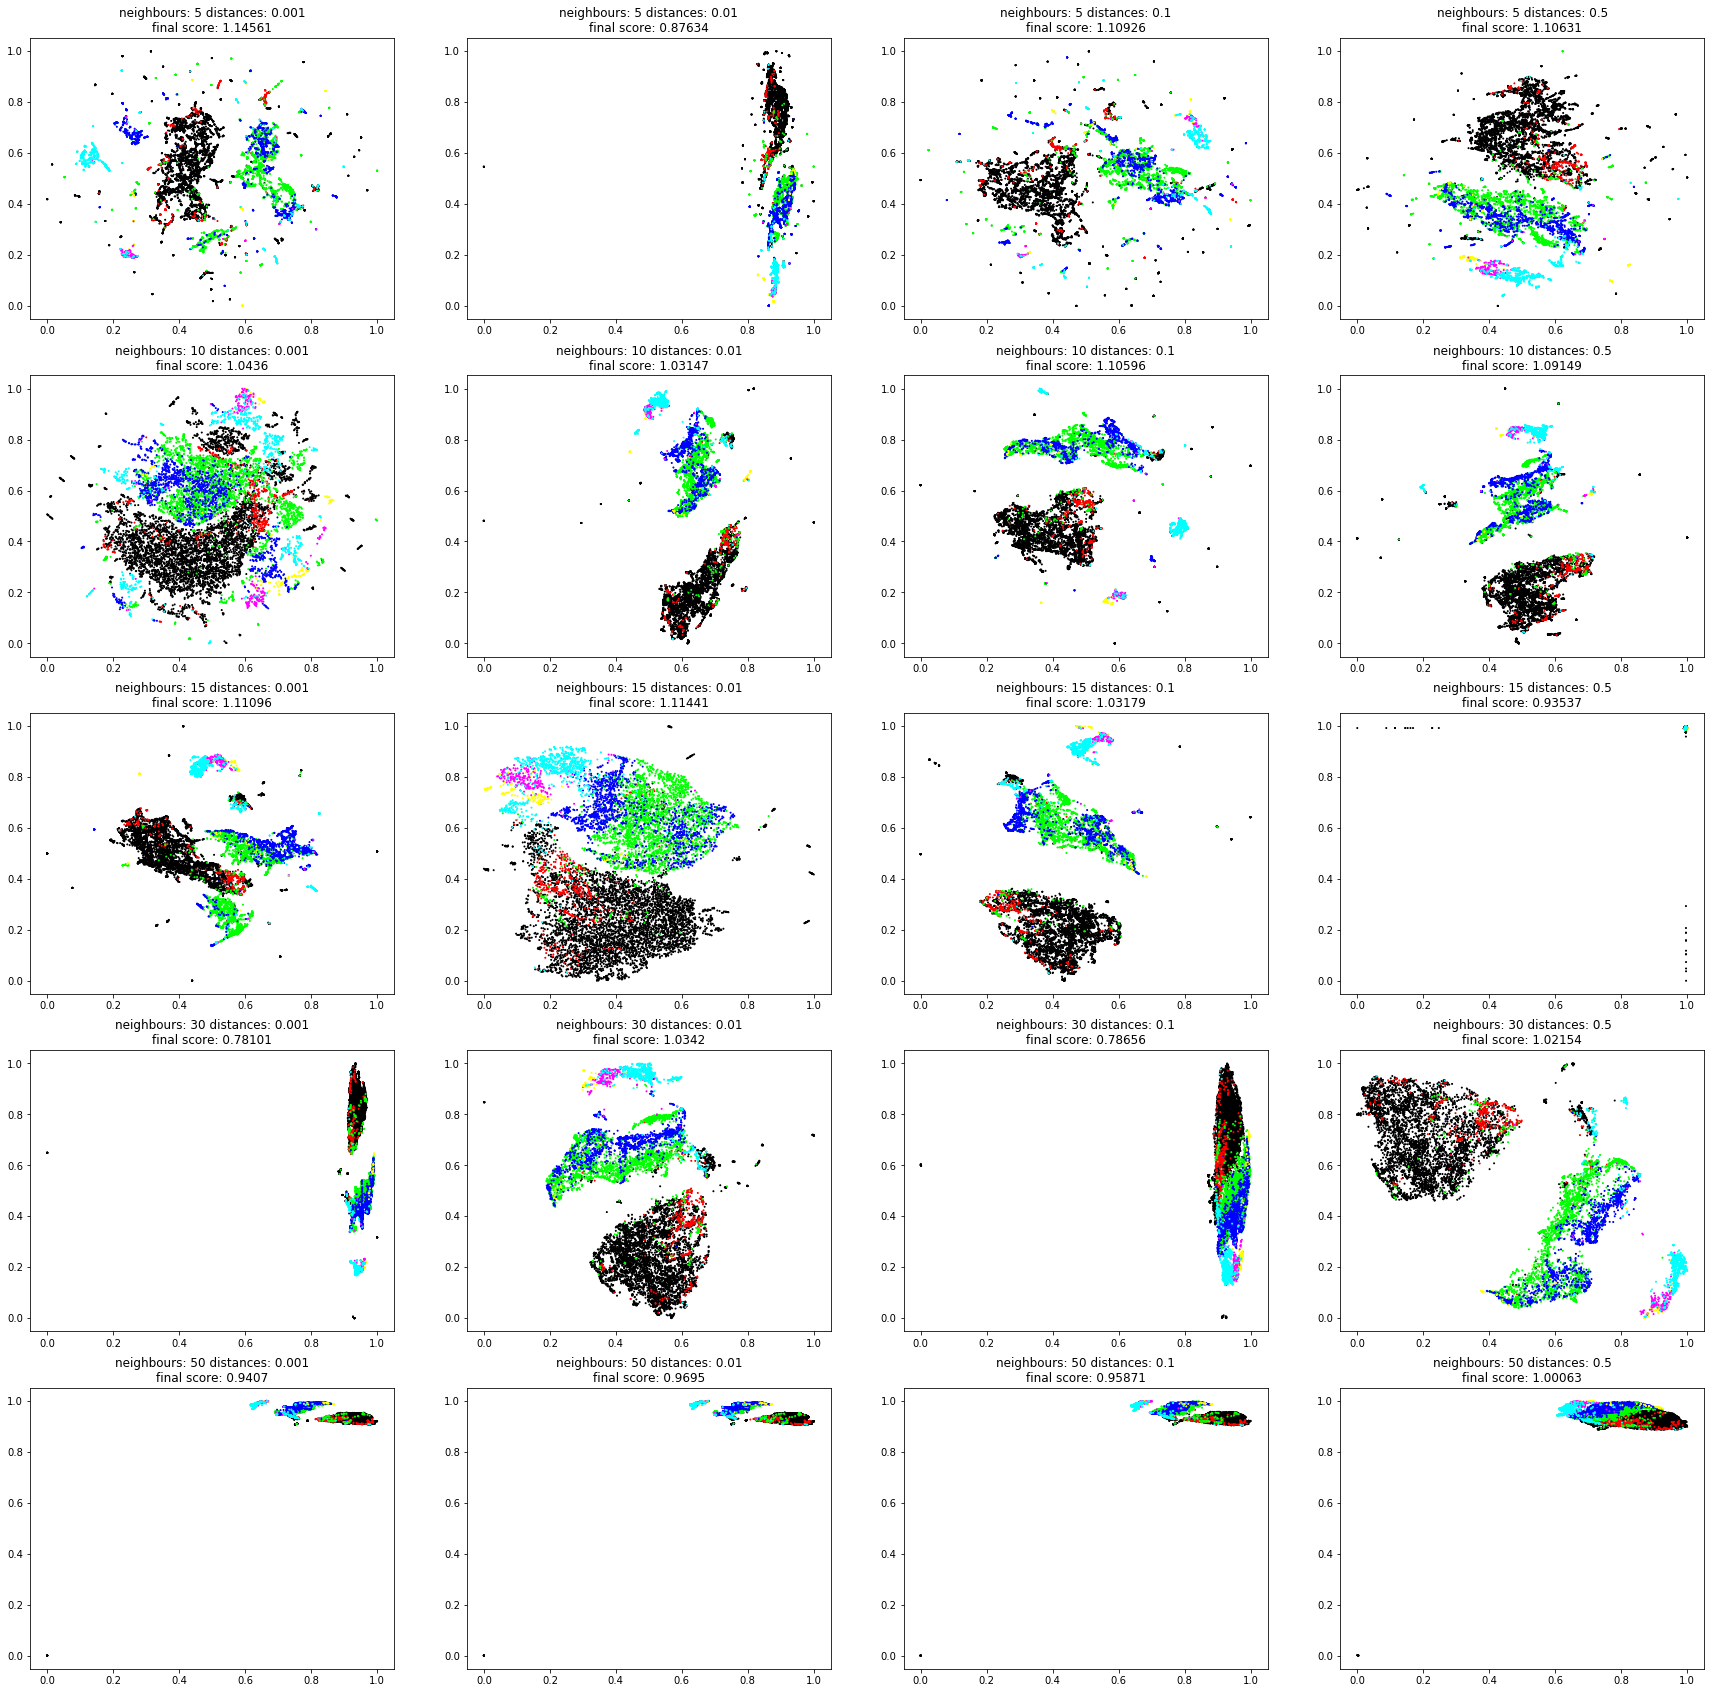

In [228]:
plotUMAPmap(umap_map_dict['wavenet'],y_data_labels)

In [234]:
#We select the best performing UMAP embeddings for each feature. These tended to be either 
# neigbours = 15, distances = 0.1 (index 9) or
# neighbours = 50, distances = 0.5 (index -1)
umap_data_dict = {}
umap_data_dict['stft'] = umap_map_dict['stft'][9]
umap_data_dict['mfcc'] = umap_map_dict['mfcc'][-1]
umap_data_dict['mir'] = umap_map_dict['mir'][9]
umap_data_dict['wavenet'] = umap_map_dict['wavenet'][9]

In [236]:
# Return all metrics for each best UMAP+feature combination and store in a dictionary
umap_scores_dict = {}
for feature_name in feature_list:
    umap_scores_dict[feature_name] = evalMetrics(umap_data_dict[feature_name], y_data_labels)

### Best UMAP on STFT

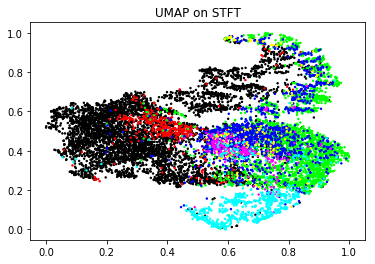

metric		 score
___________________________________
Silhouette	-0.089652802974
Roundess 	0.83453799387
Overlap  	0.183241862569
-----------------------------------
Final Score	0.928127053465


In [238]:
plot2D(umap_data_dict['stft'],colorMap,'UMAP','STFT')
printMetrics(umap_scores_dict['stft'])

### Best UMAP on MFCC

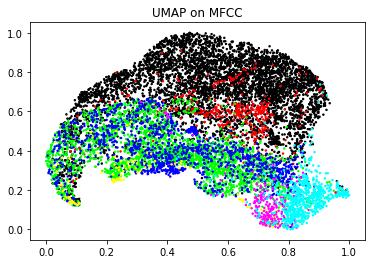

metric		 score
___________________________________
Silhouette	-0.0483545963031
Roundess 	0.789746121516
Overlap  	0.205342761074
-----------------------------------
Final Score	0.946734286287


In [239]:
plot2D(umap_data_dict['mfcc'],colorMap,'UMAP','MFCC')
printMetrics(umap_scores_dict['mfcc'])

### Best UMAP on MIR

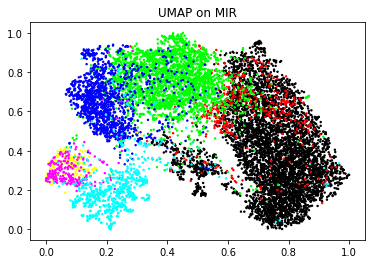

metric		 score
___________________________________
Silhouette	0.124869040795
Roundess 	0.786324676493
Overlap  	0.243271462981
-----------------------------------
Final Score	1.15446518027


In [240]:
plot2D(umap_data_dict['mir'],colorMap,'UMAP','MIR')
printMetrics(umap_scores_dict['mir'])

### Best UMAP on WaveNet

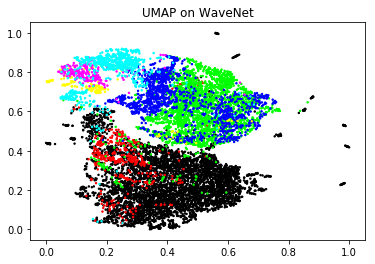

metric		 score
___________________________________
Silhouette	0.0593675891373
Roundess 	0.796825285948
Overlap  	0.258218466873
-----------------------------------
Final Score	1.11441134196


In [241]:
plot2D(umap_data_dict['wavenet'],colorMap,'UMAP','WaveNet')
printMetrics(umap_scores_dict['wavenet'])